In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from statsmodels.tsa.api import ExponentialSmoothing,SimpleExpSmoothing,Holt
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

In [32]:
df=pd.read_csv("gold_monthly_csv.csv")
df.head()

,Date,Price
0,1950-01,34.73
1,1950-02,34.73
2,1950-03,34.73
3,1950-04,34.73
4,1950-05,34.73


In [33]:
df.shape

(847, 2)

In [36]:
print(f"Date range of gold prices available from-{df.loc[:,'Date'][0]} to {df.loc[:,'Date'][len(df)-1]}") 

Date range of gold prices available from-1950-01 to 2020-07


In [37]:
date=pd.date_range(start='1/1/1950',end='8/1/2020',freq='M')
date

DatetimeIndex(['1950-01-31', '1950-02-28', '1950-03-31', '1950-04-30',
               '1950-05-31', '1950-06-30', '1950-07-31', '1950-08-31',
               '1950-09-30', '1950-10-31',
               ...
               '2019-10-31', '2019-11-30', '2019-12-31', '2020-01-31',
               '2020-02-29', '2020-03-31', '2020-04-30', '2020-05-31',
               '2020-06-30', '2020-07-31'],
              dtype='datetime64[ns]', length=847, freq='M')

In [38]:
df['month']=date
df.drop('Date',axis=1,inplace=True)
df=df.set_index('month')
df.head()

,Price
month,
1950-01-31,34.73
1950-02-28,34.73
1950-03-31,34.73
1950-04-30,34.73
1950-05-31,34.73


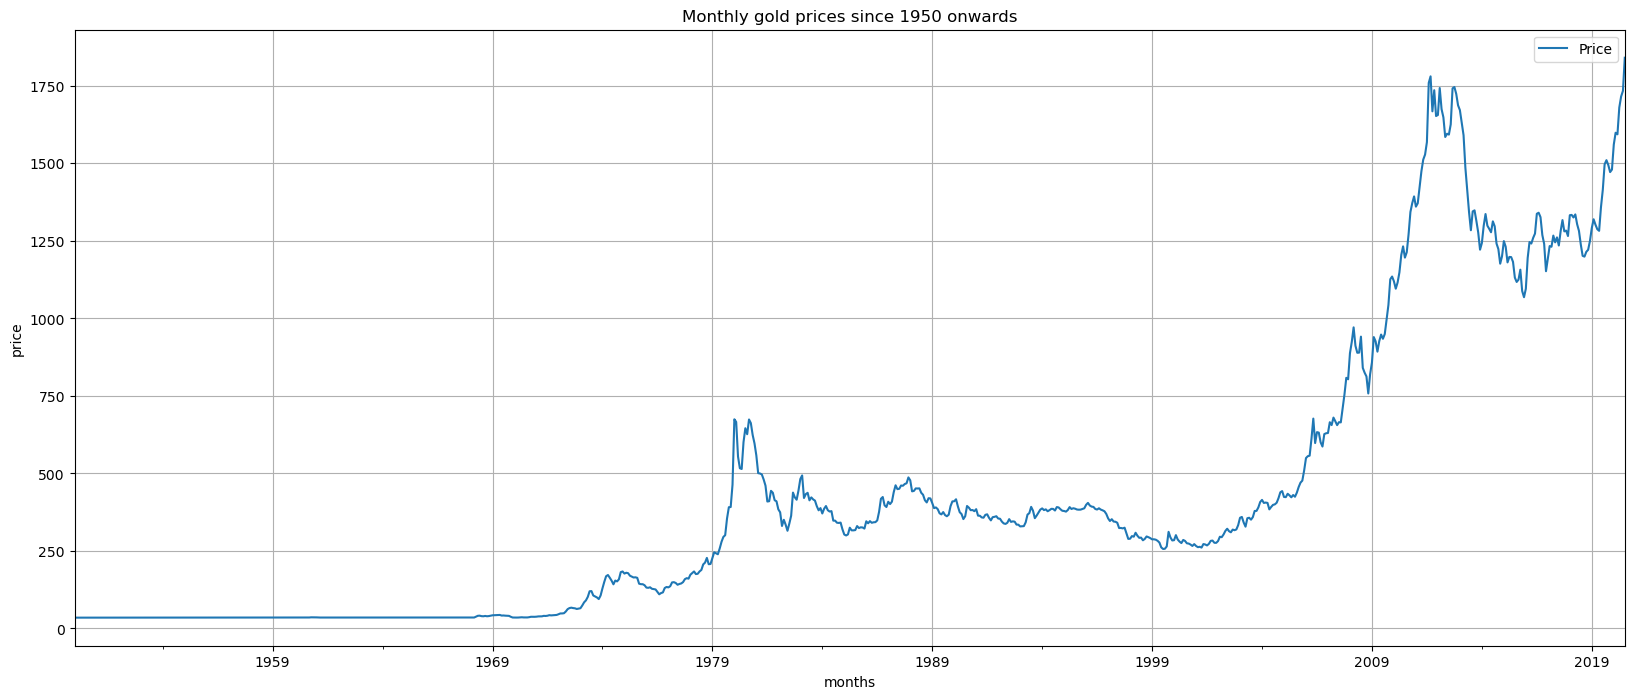

In [40]:
df.plot(figsize=(20,8))
plt.title("Monthly gold prices since 1950 onwards")
plt.xlabel("months")
plt.ylabel("price")
plt.grid()

In [41]:
round(df.describe(),3)

,Price
count,847.000
mean,416.557
std,453.665
min,34.490
25%,35.190
50%,319.622
75%,447.029
max,1840.807


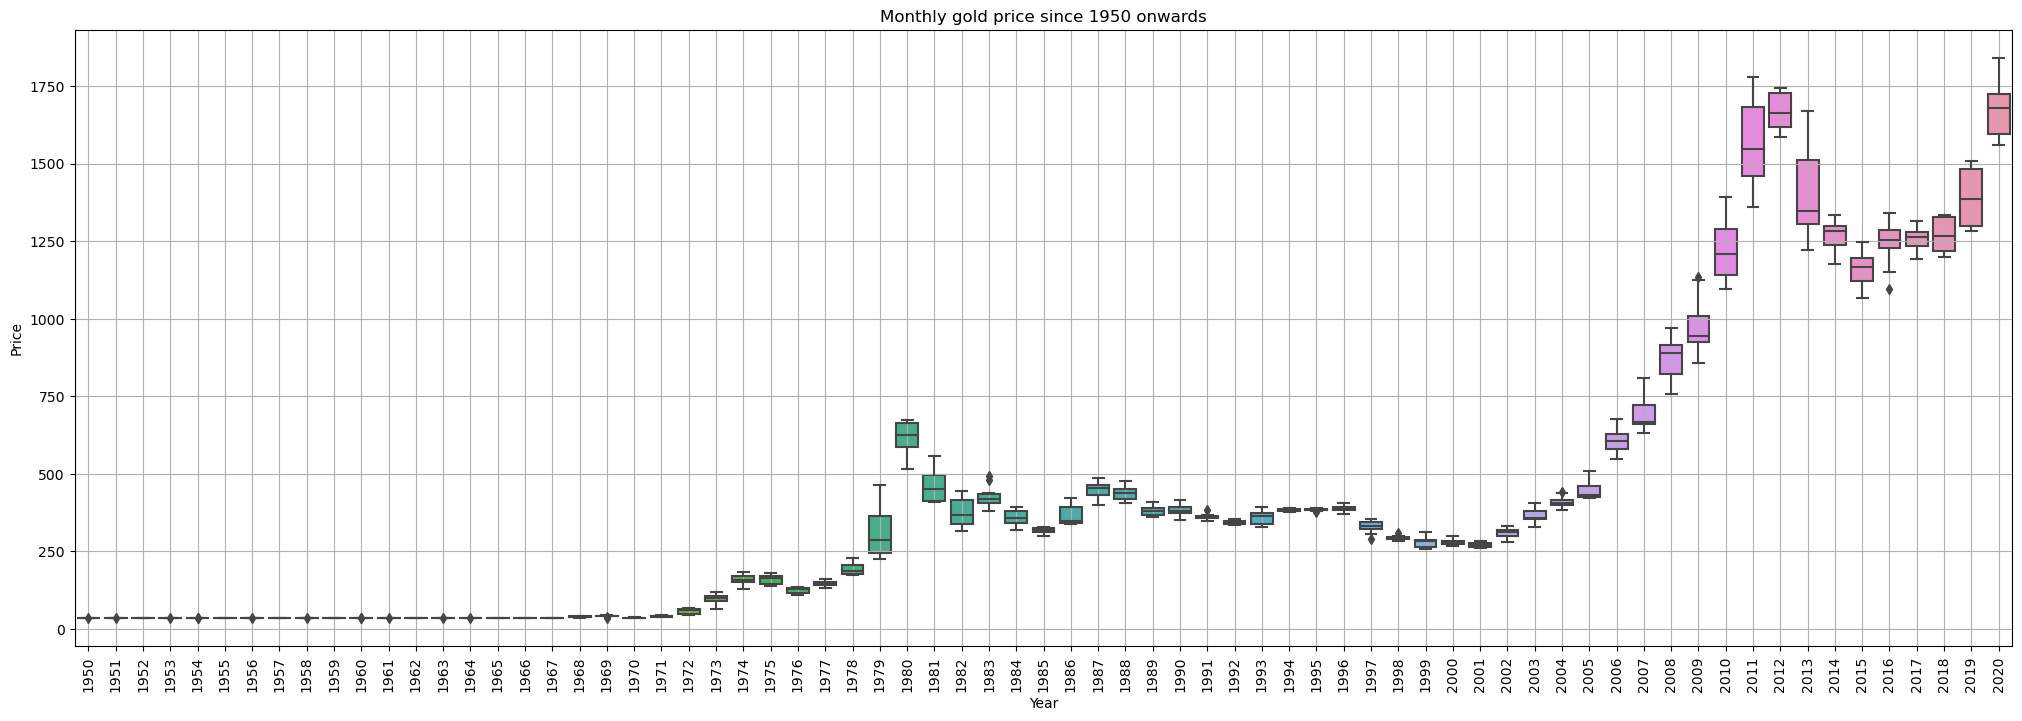

In [43]:
_, ax=plt.subplots(figsize=(25,8))
sns.boxplot(x=df.index.year,y=df.values[:,0],ax=ax)
plt.title('Monthly gold price since 1950 onwards')
plt.xlabel('Year')
plt.ylabel('Price')
plt.xticks(rotation=90)
plt.grid();

Text(0.5, 1.0, 'Monthly gold price since 1950 onwards')

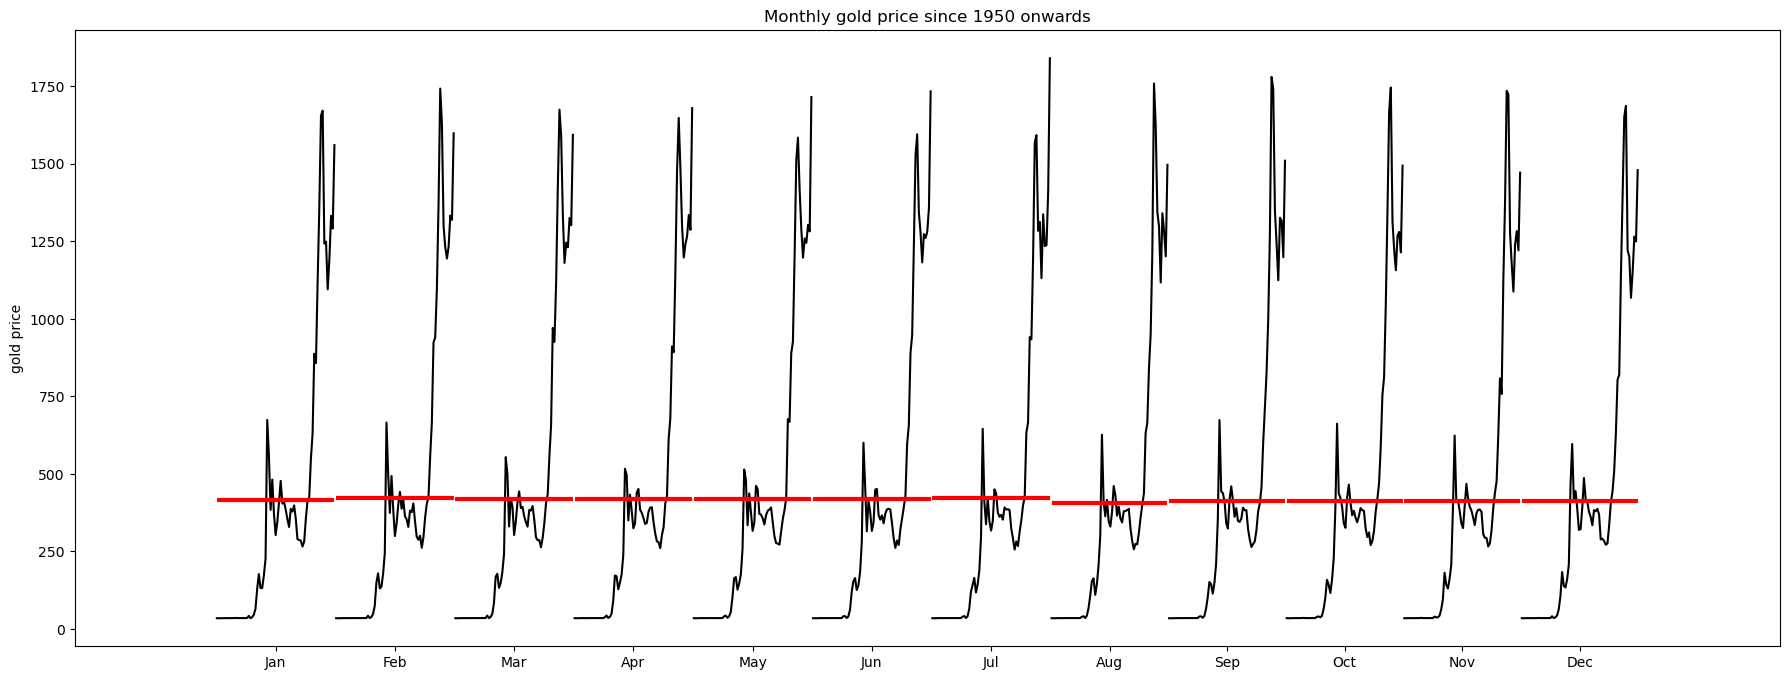

In [46]:
from statsmodels.graphics.tsaplots import month_plot

fig,ax=plt.subplots(figsize=(22,8))
month_plot(df,ylabel='gold price', ax=ax)
plt.title('Monthly gold price since 1950 onwards')

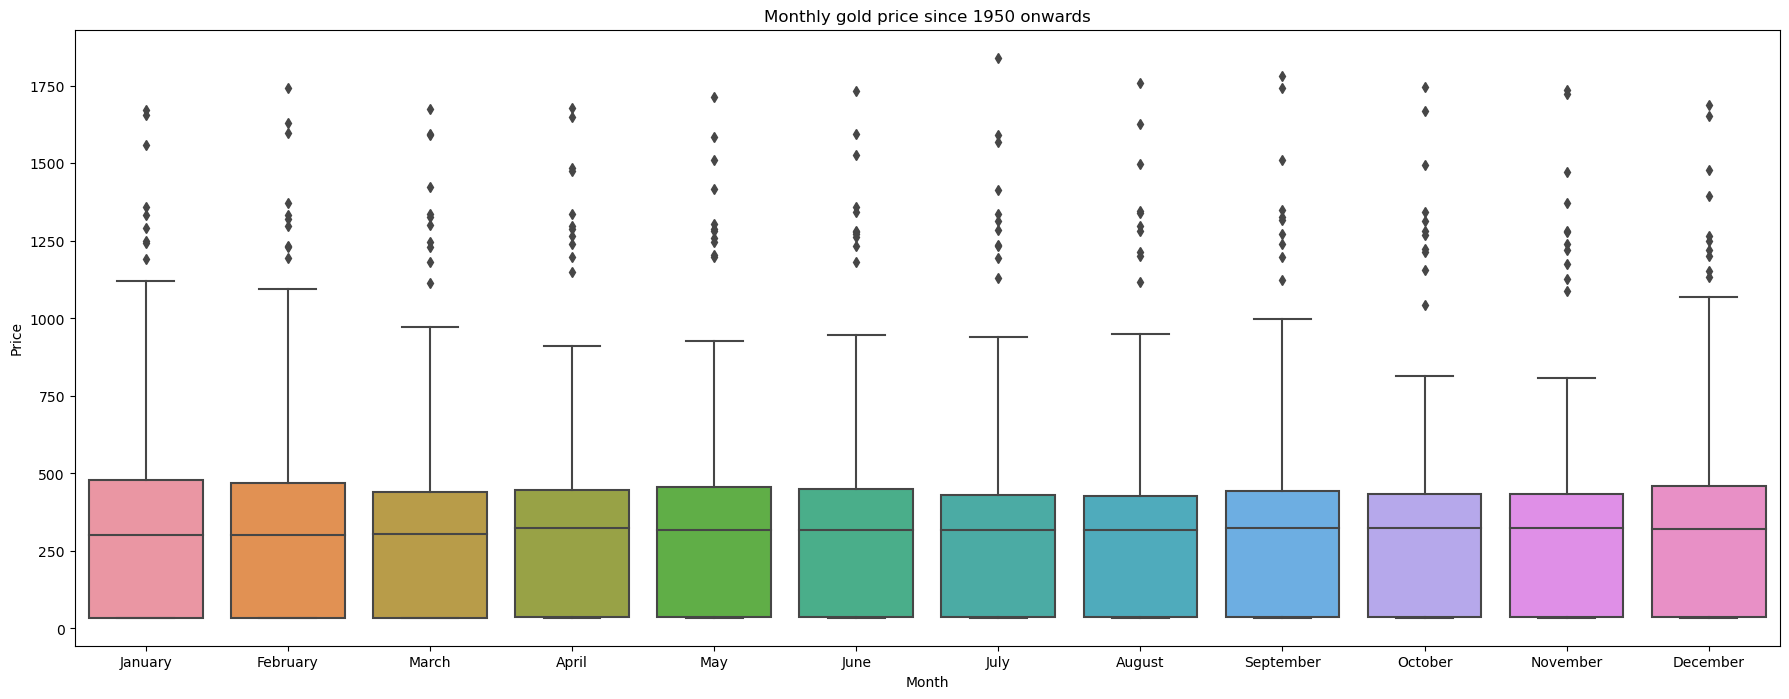

In [48]:
_, ax=plt.subplots(figsize=(22,8))
sns.boxplot(x=df.index.month_name(),y=df.values[:,0],ax=ax)
plt.title('Monthly gold price since 1950 onwards')
plt.xlabel('Month')
plt.ylabel('Price')
plt.show()

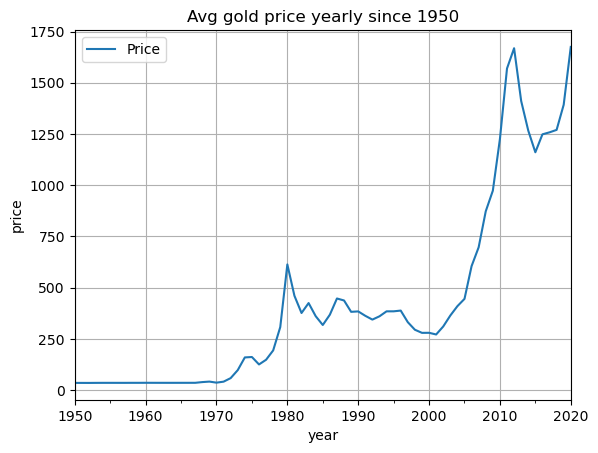

In [49]:
df_yearly_sum=df.resample('A').mean()
df_yearly_sum.plot()
plt.title('Avg gold price yearly since 1950')
plt.xlabel('year')
plt.ylabel('price')
plt.grid();

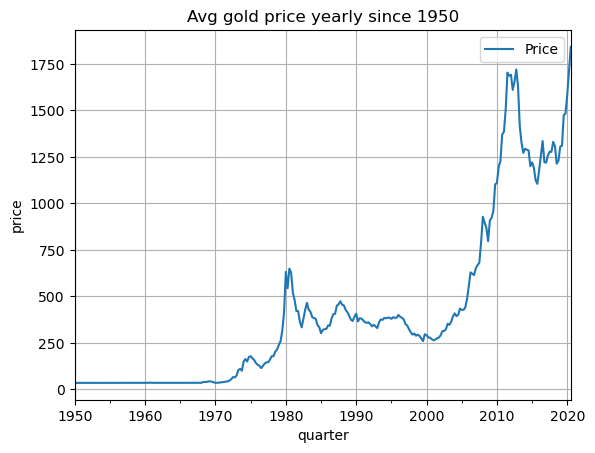

In [50]:
df_quaterly_sum=df.resample('Q').mean()
df_quaterly_sum.plot()
plt.title('Avg gold price yearly since 1950')
plt.xlabel('quarter')
plt.ylabel('price')
plt.grid();

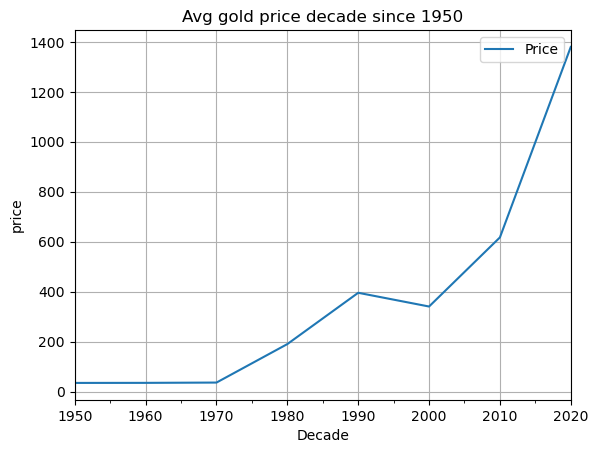

In [51]:
df_decade_sum=df.resample('10Y').mean()
df_decade_sum.plot()
plt.title('Avg gold price decade since 1950')
plt.xlabel('Decade')
plt.ylabel('price')
plt.grid();

In [54]:
df_1=df.groupby(df.index.year).mean().rename(columns={'Price':'Mean'})
df_1=df_1.merge(df.groupby(df.index.year).std().rename(columns={'Price':'Std'}),left_index=True,right_index=True)
df_1['Cov_pct']=((df_1['Std']/df_1["Mean"])*100).round(2)
df_1.head()

,Mean,Std,Cov_pct
month,,,
1950,34.729167,0.002887,0.01
1951,34.717500,0.020057,0.06
1952,34.628333,0.117538,0.34
1953,34.879167,0.056481,0.16
1954,35.020000,0.082792,0.24


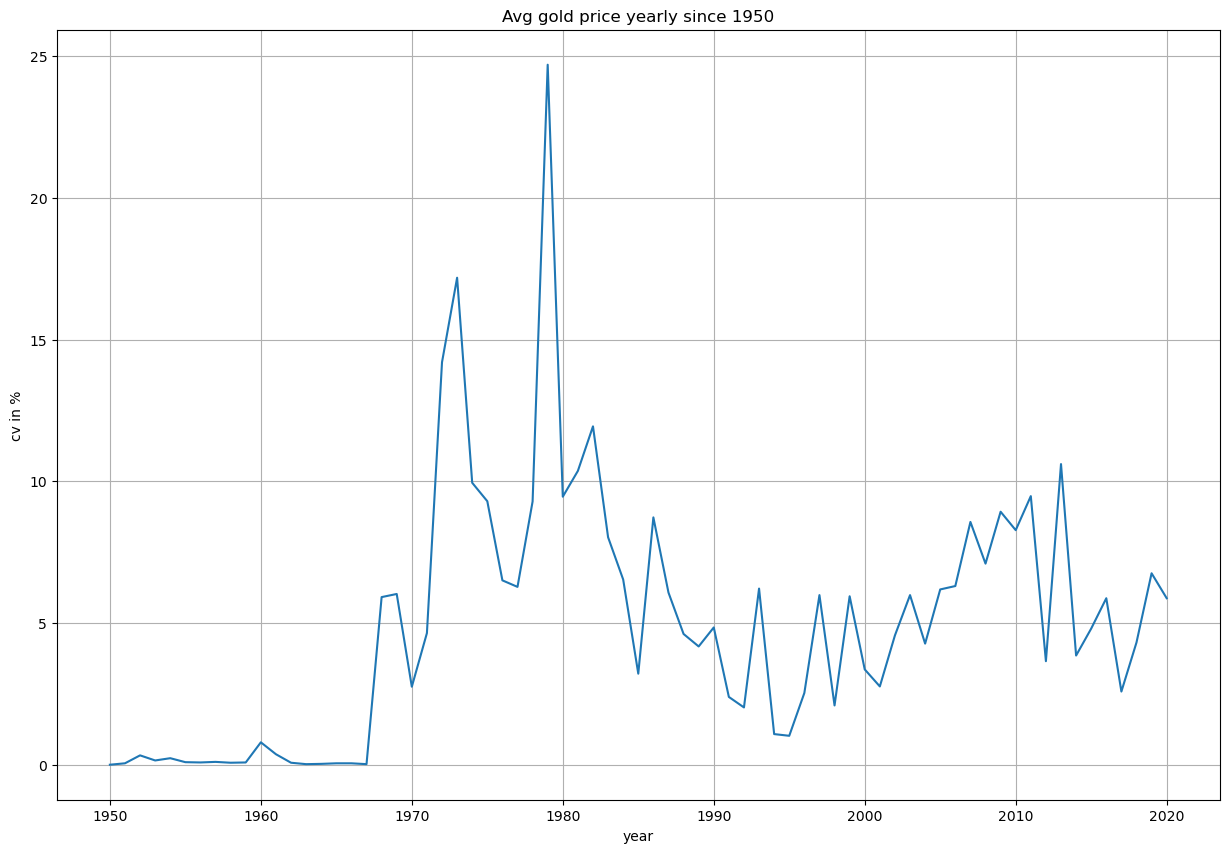

In [55]:
fig,ax=plt.subplots(figsize=(15,10))
df_1['Cov_pct'].plot();
plt.title("Avg gold price yearly since 1950")
plt.xlabel('year')
plt.ylabel('cv in %')
plt.grid()

In [56]:
train=df[df.index.year<=2015]
test=df[df.index.year>2015]

In [57]:
print(train.shape)
print(test.shape)

(792, 1)
(55, 1)


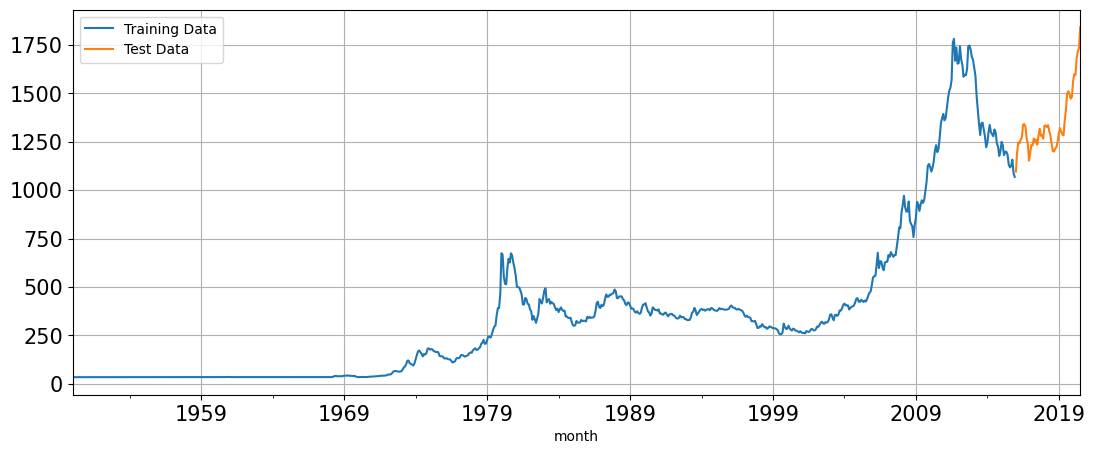

In [58]:
train["Price"].plot(figsize=(13,5),fontsize=15)
test["Price"].plot(figsize=(13,5),fontsize=15)
plt.grid()
plt.legend(['Training Data','Test Data'])
plt.show()

In [60]:
train_time=[i+1 for i in range(len(train))]
test_time=[i+len(train)+1 for i in range(len(test))]
len(train_time),len(test_time)

(792, 55)

In [61]:
LR_train=train.copy()
LR_test=test.copy()


In [62]:
LR_train['time']=train_time
LR_test['time']=test_time

In [65]:
lr=LinearRegression()
lr.fit(LR_train[['time']],LR_train["Price"].values)

LinearRegression()

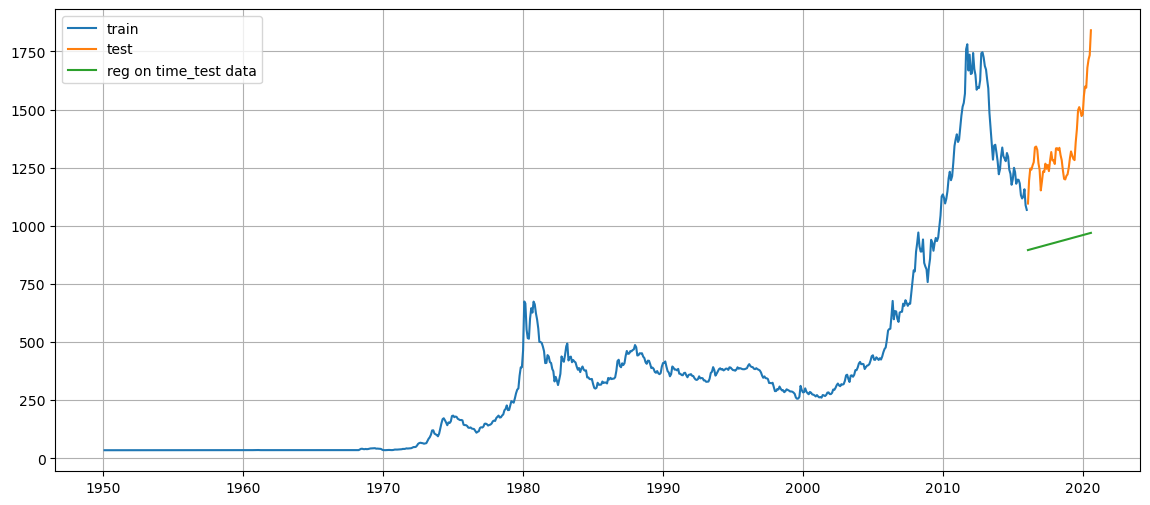

In [67]:
test_predictions_model1=lr.predict(LR_test[["time"]])
LR_test['forecast']=test_predictions_model1

plt.figure(figsize=(14,6))
plt.plot(train['Price'],label='train')
plt.plot(test['Price'],label='test')
plt.plot(LR_test['forecast'],label='reg on time_test data')
plt.legend(loc='best')
plt.grid();


In [73]:
def mape(actual,pred):
    return round(np.mean(abs(actual-pred)/actual)*100,2)

In [74]:
mape_model1_test=mape(test['Price'].values,test_predictions_model1)
print("MAPE is %3.3f"%(mape_model1_test),"%")

MAPE is 29.760 %


In [76]:
results=pd.DataFrame({'Test Mape (%)':[mape_model1_test]},index=["RegressionTime"])
results

,Test Mape (%)
RegressionTime,29.76


In [77]:
Naive_train=train.copy()
Naive_test=test.copy()

In [78]:
Naive_test['naive']=np.asarray(train['Price'])[len(np.asarray(train['Price']))-1]
Naive_test['naive'].head()

month
2016-01-31    1068.317
2016-02-29    1068.317
2016-03-31    1068.317
2016-04-30    1068.317
2016-05-31    1068.317
Name: naive, dtype: float64

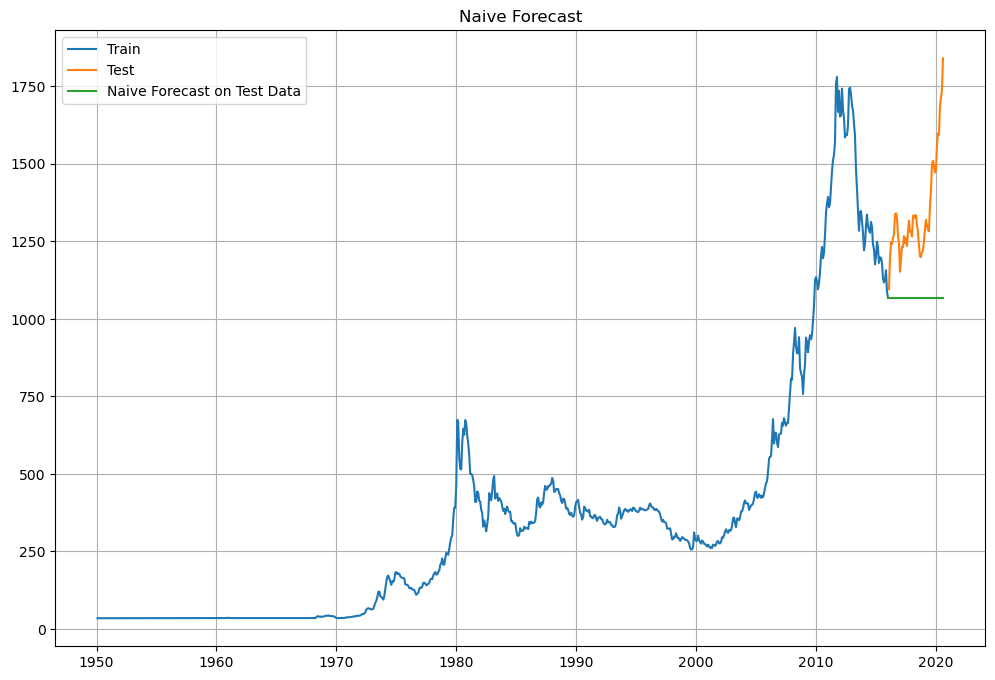

In [80]:
plt.figure(figsize=(12,8))
plt.plot(Naive_train['Price'],label='Train')
plt.plot(test['Price'],label='Test')
plt.plot(Naive_test['naive'],label='Naive Forecast on Test Data')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.grid()

In [81]:
mape_model2_test=mape(test['Price'].values,Naive_test['naive'].values)
print("For Naive forecast on the Test Data, MAPE is %3.3f"%(mape_model2_test),"%")

For Naive forecast on the Test Data, MAPE is 19.380 %


In [82]:
resultsDf_2=pd.DataFrame({'Test Mape (%)':[mape_model2_test]},index=["NaiveModel"])
results=pd.concat([results,resultsDf_2])
results

,Test Mape (%)
RegressionTime,29.76
NaiveModel,19.38


In [83]:
final_model=ExponentialSmoothing(df,
                                trend='additive',
                                seasonal='additive').fit(smoothing_level=0.4,
                                                        smoothing_trend=0.3,
                                                        smoothing_seasonal=0.6)

In [94]:
Mape_final_model=mape(df['Price'].values,final_model.fittedvalues)
print("MAPE:",Mape_final_model)

MAPE: 17.24


In [95]:
predictions=final_model.forecast(steps=len(test))

In [96]:
ddof=1
pred_df=pd.DataFrame({'lower_CI':prediction-1.96*np.std(final_model.resid,ddof-1),
                     'prediction':prediction,
                     'upper_CI':prediction+1.96*np.std(final_model.resid,ddof-1)})
pred_df.head()

,lower_CI,prediction,upper_CI
2020-08-31,1684.780611,1792.867721,1900.954831
2020-09-30,1615.362041,1723.449152,1831.536262
2020-10-31,1538.618729,1646.705839,1754.792950
2020-11-30,1476.804353,1584.891463,1692.978574
2020-12-31,1459.368754,1567.455865,1675.542975


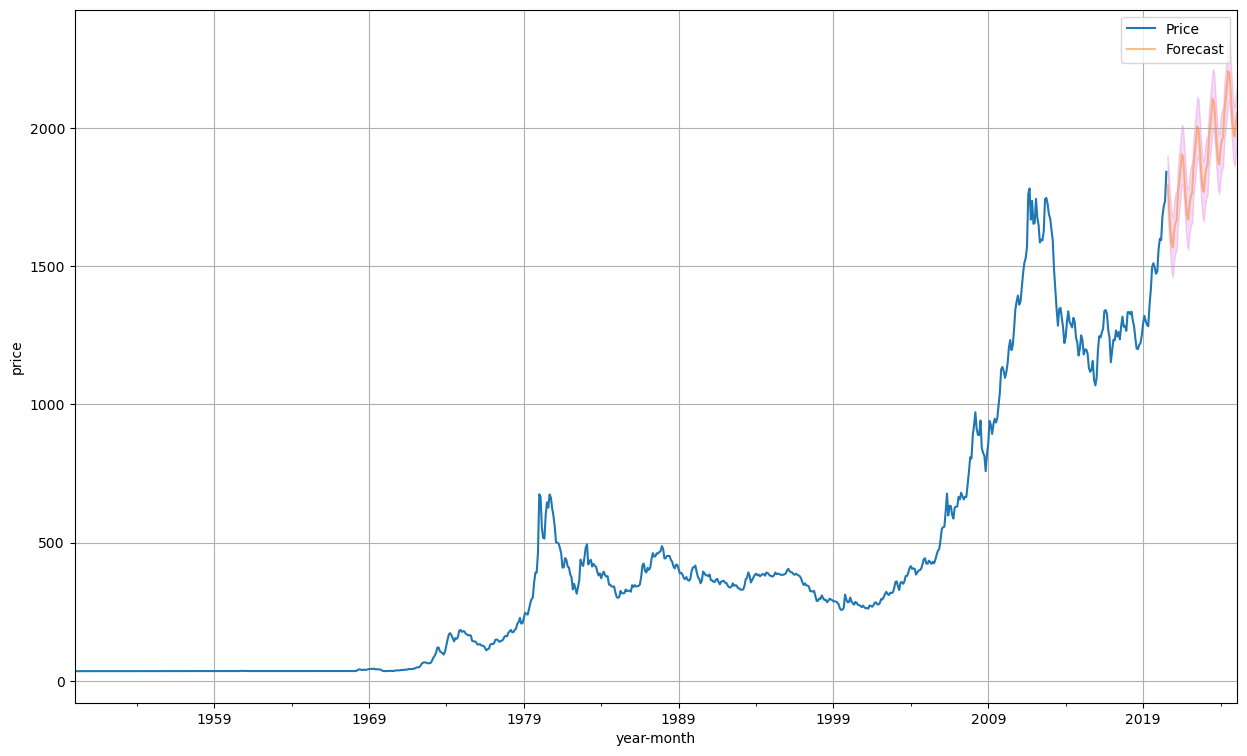

In [99]:
axis=df.plot(label='Actual',figsize=(15,9))
pred_df['prediction'].plot(ax=axis,label='Forecast',alpha=0.5)
axis.fill_between(pred_df.index,pred_df['lower_CI'],pred_df['upper_CI'],color='m',alpha=0.15)
axis.set_xlabel('year-month')
axis.set_ylabel('price')
plt.legend(loc='best')
plt.grid()
plt.show()